<a href="https://colab.research.google.com/github/samkirwanppb/UCDPA_SamKirwan/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning


In [300]:
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid") ### might have to put this into the function below. we will see in time. 
sns.color_palette("Spectral", as_cmap=True) #this changes the relplot, hue is different in the lm plot
sns.set()


hsite = "https://e.infogram.com/_/bQHbMUkcBdD1LFGscrW5?parent_url=https%3A%2F%2Fwww.theirishfield.ie%2Fstallion-fees-up-to-date-fees-for-more-than-400-stallions-for-2023-738173&src=embed#async_embed"
res = requests.get(hsite)
soup = bs(res.content, "html.parser")
#soup


x = soup.find_all("script")[4]
## really good use of regex here i think to get the data from there.

string = str(x)
print(string[0:2000])###dont print all of it, looks bad in github

<script>window.infographicData={"id":318959736,"type":0,"block_id":"023467ec-1db7-4ba5-90b3-12e78f43dcf4","theme_id":258,"user_id":2114665,"team_user_id":805284,"path":"a0ff400d-32c4-4e46-bde8-a093a04e1b11","title":"Stallion fees 2023 wk48","description":"","tags":"","public":false,"publicAccess":false,"private_link_enabled":1,"thumb":"https:\u002F\u002Finfogram-thumbs-200.s3-eu-west-1.amazonaws.com\u002F023467ec-1db7-4ba5-90b3-12e78f43dcf4.jpg","embedImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F6c657eaada927282c6ba8f94485caba4.png","previewImageUrl":"https:\u002F\u002Finfogram.io\u002Fp\u002F90c07788e8331dd681e583525fa6ab72.png","width":599,"copyright":"","properties":{"tabs":true,"custom_logo":"none","embed_button":"disabled","transparent":true,"zeropaddingembed":"true","title_link":"infogram","customLinkOption":"text","footerSettings":{},"publishType":1,"rtl":false,"language":"en","export_settings":{"showGrid":true,"showValues":true},"whitelabel":true,"noTracking":false,"dec

In [301]:
raw_data = re.findall(r'\[(.*?)\]', string)


##the below is a reusable function. When inputting the list returned from the regex pattern this will return the desired elements that we would like to keep
def clean_data(data):
  data_filtered = []
  for i in data:
    if len(i) != 0: ##removes empty strings in the list 
        if i[0] == '"' and i[-2:] == ')"': ##these are the charactorists of the strings that we want to keep.
            i = i.replace('"', '')#removing all the "'s from the data
            data_filtered.append(i)

  return data_filtered

data_lst = clean_data(raw_data)

print(data_lst[0:5])

['Acclamation,Rathbarry,€27,500 (€27,500)', 'Alkumait,Castlefield,€5,000 (€5,000)', 'Arizona,Coolmore,€5,000 (€6,000)', 'Australia,Coolmore,€25,000 (€35,000)', 'Awtaad,Derrinstown,€5,000 (€5,000)']


In [302]:
data_dic = {}
for i in data_lst:
  data_dic[i.split(",", 2)[0]] = [i.split(",", 2)[1],i.split(",", 2)[2]]

col = ['Sire','Stud', 'Fee']
fee_data = pd.DataFrame.from_dict(data_dic, orient='index').reset_index()
fee_data.set_axis(col, axis = 1, inplace = True)
fee_data.head()

,Sire,Stud,Fee
0,Acclamation,Rathbarry,"€27,500 (€27,500)"
1,Alkumait,Castlefield,"€5,000 (€5,000)"
2,Arizona,Coolmore,"€5,000 (€6,000)"
3,Australia,Coolmore,"€25,000 (€35,000)"
4,Awtaad,Derrinstown,"€5,000 (€5,000)"


In [303]:
##cleaning the fee column. the first price is the 2023 years fee, the price in brackets is the 2022 fee (last year)
fee_data['Fee 2023'] = fee_data['Fee'].str.split("(").str[0].str.strip()
fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")
fee_data.head()

<ipython-input-303-7e5f14fa7953>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee'].str.split("(").str[1].str.strip().str.replace(")", "")


,Sire,Stud,Fee,Fee 2023,Fee 2022
0,Acclamation,Rathbarry,"€27,500 (€27,500)","€27,500","€27,500"
1,Alkumait,Castlefield,"€5,000 (€5,000)","€5,000","€5,000"
2,Arizona,Coolmore,"€5,000 (€6,000)","€5,000","€6,000"
3,Australia,Coolmore,"€25,000 (€35,000)","€25,000","€35,000"
4,Awtaad,Derrinstown,"€5,000 (€5,000)","€5,000","€5,000"


In [304]:
fee_data['Fee 2022'].value_counts().head() ##shows this akward that is there as new

NEW        34
€5,000     22
$10,000    16
€15,000    10
€4,000      9
Name: Fee 2022, dtype: int64

In [305]:
#replacing the new value with nans
fee_data['Fee 2022'] = fee_data['Fee 2022'].replace('NEW', np.nan)
fee_data['Fee 2022'].value_counts().head()#new is gone and replaced with NP.nan

€5,000     22
$10,000    16
€15,000    10
€4,000      9
$12,500     8
Name: Fee 2022, dtype: int64

In [306]:
##careful reruning this, if no fee has changed currency can use the following - fee_data[['Currency 2023', 'Currency 2022']] = fee_data['Fee'].str[0] 
##as can be seen in the above code the fee columns still need some cleaning. also an important observation is that the currencyies for the fees are different for certain stallions
#so I will create a column that stores the currencies so that we can convert them all into the one
fee_data['Currency 2023'] = fee_data['Fee 2023'].str[0] 
fee_data['Currency 2022'] = fee_data['Fee 2022'].str[0]
#clean the Fee 2022 and Fee 2023 columns so that they are ints
fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
fee_data.head()

<ipython-input-306-385ba18f6ebe>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2023'] = fee_data['Fee 2023'].str.replace("€", "").str.replace("£", "").str.replace("$", "")
<ipython-input-306-385ba18f6ebe>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fee_data['Fee 2022'] = fee_data['Fee 2022'].str.replace("€", "").str.replace("£", "").str.replace("$", "")


,Sire,Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022
0,Acclamation,Rathbarry,"€27,500 (€27,500)","27,500","27,500",€,€
1,Alkumait,Castlefield,"€5,000 (€5,000)","5,000","5,000",€,€
2,Arizona,Coolmore,"€5,000 (€6,000)","5,000","6,000",€,€
3,Australia,Coolmore,"€25,000 (€35,000)","25,000","35,000",€,€
4,Awtaad,Derrinstown,"€5,000 (€5,000)","5,000","5,000",€,€


In [307]:
fee_data['Fee'].str.split("(").str[0]

0       €27,500 
1        €5,000 
2        €5,000 
3       €25,000 
4        €5,000 
         ...    
306     $12,500 
307    $100,000 
308     $25,000 
309     $30,000 
310     $10,000 
Name: Fee, Length: 311, dtype: object

In [308]:
##performance_ratings will be used to see if a horse has had 1,2,3,4 or 5+ runs - wont be perfect but worth a go
performance_figures = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/performance_figures.csv')
##remove National Hunt ratings. #meh will come back to it, not sure will I need this table really. 
performance_figures.head()

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,T:73,T:79,T:72,T:63,T:74,T:80
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,A:42,T:47,T:x,T:x,T:x,-
2,A DEFINITE GETAWAY (IRE),2018,GELDING,Ben Pauling,H:x,H:x,H:x,-,-,-
3,A DIFFERENT KIND (IRE),2017,GELDING,Donald McCain,H:93,H:135,H:x,H:x,H:x,H:x
4,A E HOUSMAN (GB),2019,COLT,NaN,T:71,A:x,A:x,T:x,T:x,-


In [309]:
def clean_peformance_figures(data, column):  
  data = data[~data[column].str.contains("H")]
  data = data[~data[column].str.contains("S")]
  data = data[~data[column].str.contains("N")]
  data[column] = data[column].str.replace(":","").str.replace("T", "").str.replace("A","")
  return data

for i in performance_figures.columns[-6:]:
  performance_figures = clean_peformance_figures(performance_figures, i)

performance_figures = performance_figures.replace("-", np.nan)
performance_figures['runs'] = 6 - performance_figures.iloc[:,-6:].isna().sum(axis = 1)
performance_figures.head(20)

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,73,79,72,63,74,80,6
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,42,47,x,x,x,NaN,5
4,A E HOUSMAN (GB),2019,COLT,NaN,71,x,x,x,x,NaN,5
5,A LA FRANCAISE (GB),2019,FILLY,Jim Goldie,61,71,65,61,50,63,6
6,A LADY FOREVER (GB),2019,FILLY,Robyn Brisland,x,x,x,x,NaN,NaN,4
7,A LITTLE RESPECT (IRE),2020,FILLY,Charlie Johnston,x,x,x,NaN,NaN,NaN,3
10,A SURE WELCOME (GB),2014,GELDING,John Spearing,70,64,56,82,76,83,6
11,A TASTE OF HONEY (GB),2020,FILLY,Archie Watson,x,x,x,NaN,NaN,NaN,3
13,AADDEEY (IRE),2017,GELDING,Archie Watson,83,101,103,96,96,97,6
14,AASHEQ (IRE),2013,GELDING,NaN,64,82,78,83,90,86,6


In [310]:
#performance_figures.loc[performance_figures['runs'] == 0]

In [311]:
performance_figures.head()

,Racehorse,YOF,Sex,Trainer,Latest,2 runs ago,3 runs ago,4 runs ago,5 runs ago,6 runs ago,runs
0,A BOY NAMED IVY (IRE),2018,GELDING,NaN,73,79,72,63,74,80,6
1,A DAY TO DREAM (IRE),2020,GELDING,Ollie Pears,42,47,x,x,x,NaN,5
4,A E HOUSMAN (GB),2019,COLT,NaN,71,x,x,x,x,NaN,5
5,A LA FRANCAISE (GB),2019,FILLY,Jim Goldie,61,71,65,61,50,63,6
6,A LADY FOREVER (GB),2019,FILLY,Robyn Brisland,x,x,x,x,NaN,NaN,4


In [312]:
performance_figures.columns


Index(['Racehorse', 'YOF', 'Sex', 'Trainer', 'Latest', '2 runs ago',
       '3 runs ago', '4 runs ago', '5 runs ago', '6 runs ago', 'runs'],
      dtype='object')

In [313]:
yearling_sales_sires = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales_sires.csv')
yearling_sales_sires.head()

,Stallion,Offered,Sold,High £,Av. £,Med. £,Colt Av. £,Colt Med. £,Filly Av. £,Filly Med. £,year,age
0,Dubawi,31,28,"1,690,615","796,481","669,375","830,350","682,500","640,684","486,052",2022,yearling
1,Dubawi,27,23,"2,041,931","534,327","446,250","440,212","459,375","636,998","420,000",2021,yearling
2,Galileo,23,23,"1,280,059","464,193","357,000","355,862","241,500","605,023","538,741",2021,yearling
3,Frankel,47,43,"2,940,000","584,192","338,123","689,644","325,500","406,242","352,811",2022,yearling
4,Kingman,42,31,"1,102,500","328,787","283,500","358,009","315,000","267,419","212,270",2022,yearling


In [314]:
#i think the goal here will be to predict 2023 stallion prices based on 2022 sales results, horses abilitie and 2022 fee? stud could be good too, just trying to flesh it out a bit. might get the basic sracper out if needing more data 
#we will use the 2021 sale data and whatever horses we have from 2021 to predict 2022 prices then use the findings to predict 2023 prices.  

In [315]:
##have found another source since.
ratings = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/ratings.csv')
ratings = ratings.iloc[:, :-7] 
ratings.head() #we can see that the sire column needs a quick clean in order to be merged with the other tables containing sire

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,Diff AWT
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,NaN,NaN,NaN
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,NaN,NaN,NaN
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,NaN,NaN,NaN,NaN
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,NaN,NaN,NaN,NaN
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,NaN,NaN,NaN


In [316]:
ratings['sire_merge'] = ratings['Sire'].str.split("(").str[0].str.strip().str.capitalize()
ratings.head()

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,Diff AWT,sire_merge
0,A BOY NAMED IVY (IRE),2018,GELDING,MARKAZ (IRE),ST ATHAN (GB),NaN,79.0,NaN,NaN,NaN,NaN,Markaz
1,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,NaN,NaN,NaN,Adaay
2,A DEFINITE GETAWAY (IRE),2018,GELDING,GETAWAY (GER),DEF IT VIC (IRE),Ben Pauling,NaN,NaN,NaN,NaN,NaN,Getaway
3,A DIFFERENT KIND (IRE),2017,GELDING,DOYEN (IRE),MA MINX (IRE),Donald McCain,NaN,NaN,NaN,NaN,NaN,Doyen
4,A E HOUSMAN (GB),2019,COLT,OASIS DREAM (GB),ASTRONOMY'S CHOICE (GB),NaN,82.0,NaN,NaN,NaN,NaN,Oasis dream


In [317]:
median_yearling_sales = yearling_sales_sires[['Stallion', 'Med. £', 'year']]
merged_data = ratings.merge(median_yearling_sales.pivot(index = 'Stallion', columns = 'year'), left_on = 'sire_merge', right_on = 'Stallion')
merged_data.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,Diff AWT,sire_merge,"(Med. £, 2021)","(Med. £, 2022)"
0,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,NaN,NaN,NaN,Adaay,"8,694","9,023"
1,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,NaN,NaN,NaN,NaN,Adaay,"8,694","9,023"
2,ADAAY ATATIME (IRE),2019,GELDING,ADAAY (IRE),GLACIER POINT (GB),NaN,52.0,NaN,NaN,NaN,NaN,Adaay,"8,694","9,023"
3,ADAAY IN ASIA (GB),2019,FILLY,ADAAY (IRE),ASIA MINOR (IRE),NaN,98.0,NaN,NaN,NaN,NaN,Adaay,"8,694","9,023"
4,ADAAY TO REMEMBER (GB),2018,FILLY,ADAAY (IRE),CROSS MY HEART (GB),NaN,102.0,NaN,NaN,NaN,NaN,Adaay,"8,694","9,023"


In [318]:
merged_data = merged_data.merge(fee_data, left_on = 'sire_merge', right_on = 'Sire', how = 'left').replace(',','', regex=True).drop(columns = 'Sire_y').rename(columns = {'Sire_x': 'Sire'})
merged_data[['Fee 2022', 'Fee 2023']] = merged_data[['Fee 2022', 'Fee 2023']].fillna(0).astype(int).replace(0, np.nan)
merged_data.head()


,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,Diff AWT,sire_merge,"(Med. £, 2021)","(Med. £, 2022)",Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022
0,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,NaN,NaN,NaN,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€
1,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,NaN,NaN,NaN,NaN,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€
2,ADAAY ATATIME (IRE),2019,GELDING,ADAAY (IRE),GLACIER POINT (GB),NaN,52.0,NaN,NaN,NaN,NaN,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€
3,ADAAY IN ASIA (GB),2019,FILLY,ADAAY (IRE),ASIA MINOR (IRE),NaN,98.0,NaN,NaN,NaN,NaN,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€
4,ADAAY TO REMEMBER (GB),2018,FILLY,ADAAY (IRE),CROSS MY HEART (GB),NaN,102.0,NaN,NaN,NaN,NaN,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€


In [319]:
###note this might not be the cleanest place to put it. will revisit the vairable names at a later date, just getting the ball rolling for modeling for now. 
merged_data = merged_data.merge(performance_figures[['Racehorse', 'runs']], left_on = 'Name', right_on = 'Racehorse').drop(columns = 'Racehorse')
merged_data.head()

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,...,sire_merge,"(Med. £, 2021)","(Med. £, 2022)",Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022,runs
0,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,NaN,NaN,...,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,5
1,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,NaN,NaN,NaN,...,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,4
2,ADAAY ATATIME (IRE),2019,GELDING,ADAAY (IRE),GLACIER POINT (GB),NaN,52.0,NaN,NaN,NaN,...,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,6
3,ADAAY IN ASIA (GB),2019,FILLY,ADAAY (IRE),ASIA MINOR (IRE),NaN,98.0,NaN,NaN,NaN,...,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,6
4,ADAAY TO REMEMBER (GB),2018,FILLY,ADAAY (IRE),CROSS MY HEART (GB),NaN,102.0,NaN,NaN,NaN,...,Adaay,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,6


In [320]:
##leave a note on the data cleansing done to merge all the sets together
yearling_sales = pd.read_csv('https://raw.githubusercontent.com/samkirwanppb/UCDPA_SamKirwan/main/yearling_sales.csv').drop(columns = 'Purchaser')
yearling_sales['Sire'] = yearling_sales['Sire'].str.upper()
yearling_sales['Dam'] = yearling_sales['Dam'].str.upper()
yearling_sales['Sex'] = yearling_sales['Sex'].str.upper()
yearling_sales = yearling_sales.dropna(subset = ['Year Foaled'])
yearling_sales['Year Foaled'] = yearling_sales['Year Foaled'].astype(int)
yearling_sales.shape

(15143, 8)

In [321]:
##going to get them all in the one currency
yearling_sales.loc[~yearling_sales['Price (€)'].isna(), 'final_price'] = yearling_sales.loc[~yearling_sales['Price (€)'].isna()]['Price (€)'] * 0.88
yearling_sales.loc[~yearling_sales['Price (gns)'].isna(), 'final_price'] = yearling_sales.loc[~yearling_sales['Price (gns)'].isna()]['Price (gns)'] * 1.05
yearling_sales.loc[~yearling_sales['Price (£)'].isna(), 'final_price'] = yearling_sales.loc[~yearling_sales['Price (£)'].isna()]['Price (£)'] * 1
yearling_sales.shape

(15143, 9)

In [322]:
merged_data_test = merged_data.merge(yearling_sales.drop(columns = 'Sex'), left_on = ['Sire', 'Dam', 'Year'], right_on = ['Sire', 'Dam', 'Year Foaled'], how = 'left')

merged_data_test.head()

,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,Diff Flat,Flat Clltrl,AWT rating,...,Fee 2022,Currency 2023,Currency 2022,runs,Year Foaled,Consignor,Price (€),Price (£),Price (gns),final_price
0,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,NaN,NaN,...,4500.0,€,€,5,2020.0,"Cregg Stud, Ireland",NaN,NaN,4500.0,4725.0
1,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,NaN,NaN,NaN,...,4500.0,€,€,4,NaN,NaN,NaN,NaN,NaN,NaN
2,ADAAY ATATIME (IRE),2019,GELDING,ADAAY (IRE),GLACIER POINT (GB),NaN,52.0,NaN,NaN,NaN,...,4500.0,€,€,6,2019.0,"Church View Stables, Ireland",NaN,NaN,30000.0,31500.0
3,ADAAY IN ASIA (GB),2019,FILLY,ADAAY (IRE),ASIA MINOR (IRE),NaN,98.0,NaN,NaN,NaN,...,4500.0,€,€,6,2019.0,Whitsbury Manor Stud,NaN,NaN,10500.0,11025.0
4,ADAAY TO REMEMBER (GB),2018,FILLY,ADAAY (IRE),CROSS MY HEART (GB),NaN,102.0,NaN,NaN,NaN,...,4500.0,€,€,6,2018.0,Whitsbury Manor Stud,NaN,NaN,6000.0,6300.0


# Sales Price X Stallion Fee - Statistical Inference - might not be needed

In [323]:
stallion_data = fee_data.merge(median_yearling_sales.pivot(index = 'Stallion', columns = 'year'), left_on = 'Sire', right_on = 'Stallion').replace(',','', regex=True)
stallion_data[['Fee 2023',	'Fee 2022', stallion_data.columns[-2], stallion_data.columns[-1]]] = stallion_data[['Fee 2023',	'Fee 2022', stallion_data.columns[-2], stallion_data.columns[-1]]].astype(float)
stallion_data.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(
/usr/local/lib/python3.8/dist-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,Sire,Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022,"(Med. £, 2021)","(Med. £, 2022)"
0,Acclamation,Rathbarry,€27500 (€27500),27500.0,27500.0,€,€,54000.0,37000.0
1,Australia,Coolmore,€25000 (€35000),25000.0,35000.0,€,€,43210.0,29400.0
2,Awtaad,Derrinstown,€5000 (€5000),5000.0,5000.0,€,€,25000.0,28702.0
3,Blue Point,Kildangan,€35000 (€40000),35000.0,40000.0,€,€,NaN,73500.0
4,Bungle Inthejungle,Rathasker,€6500 (€8000),6500.0,8000.0,€,€,21000.0,10311.0


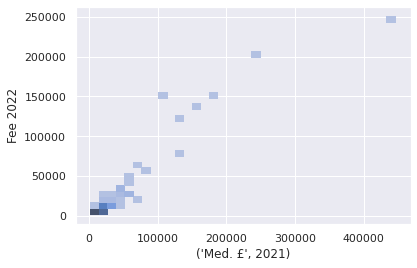

In [324]:
sns.histplot(data = stallion_data, x = stallion_data.columns[-2], y = 'Fee 2022')

In [325]:
print(stallion_data[['Fee 2023',	'Fee 2022']].dtypes)

Fee 2023    float64
Fee 2022    float64
dtype: object


# Modeling

In [326]:
merged_data_test.columns

Index([          'Name',           'Year',            'Sex',           'Sire',
                  'Dam',        'Trainer',    'Flat rating',      'Diff Flat',
          'Flat Clltrl',     'AWT rating',       'Diff AWT',     'sire_merge',
       ('Med. £', 2021), ('Med. £', 2022),           'Stud',            'Fee',
             'Fee 2023',       'Fee 2022',  'Currency 2023',  'Currency 2022',
                 'runs',    'Year Foaled',      'Consignor',      'Price (€)',
            'Price (£)',    'Price (gns)',    'final_price'],
      dtype='object')

In [327]:
###messy here but want to plough on now
col1 = merged_data_test.iloc[:,-15:-13].head().columns[0]
col2 = merged_data_test.iloc[:,-15:-13].head().columns[1]

In [328]:
###messy here but want to plough on now
data = merged_data_test[['Name', 'Year', 'Sex', 'Sire','Dam', 'Trainer', 'Flat rating', 'AWT rating', col1, col2,'Stud',            'Fee',
             'Fee 2023', 'Fee 2022',  'Currency 2023',  'Currency 2022',
                 'runs', 'Consignor', 'final_price']]
data.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,Name,Year,Sex,Sire,Dam,Trainer,Flat rating,AWT rating,"(Med. £, 2021)","(Med. £, 2022)",Stud,Fee,Fee 2023,Fee 2022,Currency 2023,Currency 2022,runs,Consignor,final_price
0,A DAY TO DREAM (IRE),2020,GELDING,ADAAY (IRE),TARA TOO (IRE),Ollie Pears,49.0,NaN,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,5,"Cregg Stud, Ireland",4725.0
1,A LADY FOREVER (GB),2019,FILLY,ADAAY (IRE),LADY FILLY (GB),Robyn Brisland,42.0,NaN,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,4,NaN,NaN
2,ADAAY ATATIME (IRE),2019,GELDING,ADAAY (IRE),GLACIER POINT (GB),NaN,52.0,NaN,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,6,"Church View Stables, Ireland",31500.0
3,ADAAY IN ASIA (GB),2019,FILLY,ADAAY (IRE),ASIA MINOR (IRE),NaN,98.0,NaN,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,6,Whitsbury Manor Stud,11025.0
4,ADAAY TO REMEMBER (GB),2018,FILLY,ADAAY (IRE),CROSS MY HEART (GB),NaN,102.0,NaN,8694,9023,Besnate,€5000 (€4500),5000.0,4500.0,€,€,6,Whitsbury Manor Stud,6300.0


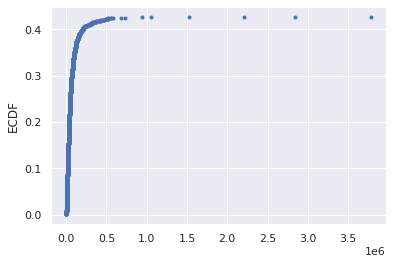

In [329]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y
  
  # Compute ECDF for versicolor data: x_vers, y_vers
x_vers, y_vers = ecdf(data['final_price'])

# Generate plot
plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')

# Label the axes
plt.xlabel('')
plt.ylabel('ECDF')

# Display the plot
plt.show()

In [330]:
#sns.histplot(data = data, x = 'final_price')

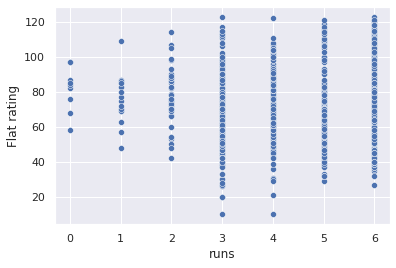

In [331]:
sns.scatterplot(data = data, x = 'runs', y = 'Flat rating')

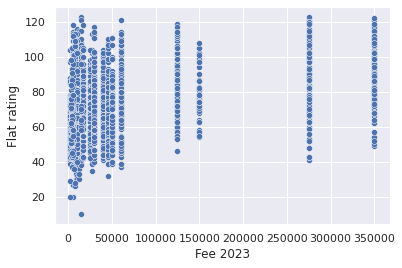

In [332]:
sns.scatterplot(data = data, x = 'Fee 2023', y = 'Flat rating')

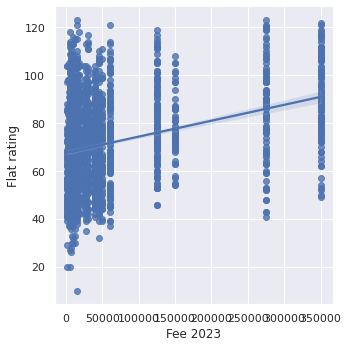

In [334]:
sns.lmplot(data = data, x = 'Fee 2023', y = 'Flat rating')

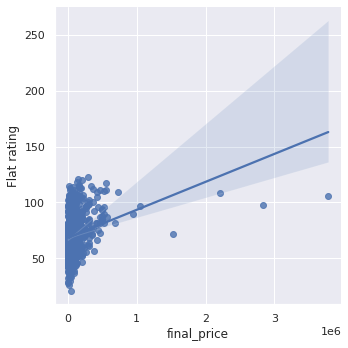

In [338]:
sns.lmplot(data = data, x = 'final_price', y = 'Flat rating')
######potential outliers to be talked about here

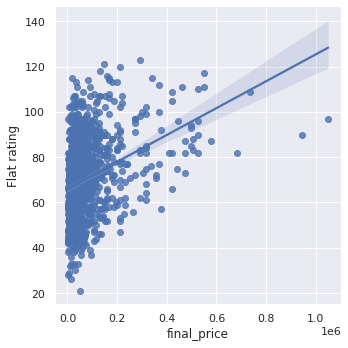

In [340]:
sns.lmplot(data = data.loc[data['final_price'] < 1280000.0 ], x = 'final_price', y = 'Flat rating')

In [339]:
data['final_price'].max()

3780000.0

In [333]:
from sklearn.module import Model
model = Model()
model.fit(X, y)
predictions = model.predict(X_new)

ModuleNotFoundError: ignored